In [1]:
import numpy as np
from scipy.integrate import odeint
import importlib.util
import scipy.stats
import matplotlib.pyplot as plt
import copy
import sys
import os
from sklearn.linear_model import LinearRegression

file_path_ekf = '/home/austin/Drone_AFRL/ekf.py'
EKF_Module = 'ekf'
# Load the EKF module
spec_ekf = importlib.util.spec_from_file_location(EKF_Module, file_path_ekf)
EKF = importlib.util.module_from_spec(spec_ekf)
sys.modules[EKF_Module] = EKF
spec_ekf.loader.exec_module(EKF)

ekf.py loaded successfully


# <center> Uploading real drone data <center>

In [2]:
# load all files in the directory /CSV into data frames with names corresponding to the file names remove "test_bag__slash" from the start of the name
import glob
import pandas as pd

# Load the data
path = '/home/austin/Drone_AFRL/CSV/'
all_files = glob.glob(path + "/*.csv")
data = {}
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    data[os.path.basename(filename)[16:-4]] = df

data = {key.replace("_slash_", "/"): value for key, value in data.items()}

for key in data.keys():
    print(key)

mavros/rc/in
optic_flow
mavros/rc/out
optic_flow/global/mean/x
optic_flow/global/mean/y
optic_flow/wind_sensor/mean/x
mavros/imu/data
optic_flow/camera/mean/x
optic_flow/camera/mean/y
drone/rpy/radians
trisonica_body_level
optic_flow/wind_sensor/mean/y
drone/rpy/degrees
mavros/local_position/pose
trisonica
trisonica_global


# <center> Optic Flow <center>

# <center> Ground Truth (Mocap) <center>

In [46]:
data['mavros/local_position/pose']

,rosbagTimestamp,header,seq,stamp,secs,nsecs,frame_id,pose,position,x,y,z,orientation,x.1,y.1,z.1,w
0,1726109483478350322,NaN,10947,NaN,1722536971,535796352,"""map""",NaN,NaN,-0.652569,-0.065167,0.263797,NaN,-0.018975,-0.025734,0.775479,-0.630563
1,1726109483504783016,NaN,10948,NaN,1722536971,556796352,"""map""",NaN,NaN,-0.653235,-0.067521,0.269789,NaN,-0.016044,-0.025491,0.776270,-0.629680
2,1726109483537233460,NaN,10949,NaN,1722536971,588796352,"""map""",NaN,NaN,-0.653975,-0.070847,0.279517,NaN,-0.014354,-0.017971,0.777786,-0.628108
3,1726109483570342591,NaN,10950,NaN,1722536971,630795328,"""map""",NaN,NaN,-0.654530,-0.075028,0.293698,NaN,-0.013301,-0.012181,0.779157,-0.626569
4,1726109483605488048,NaN,10951,NaN,1722536971,662795328,"""map""",NaN,NaN,-0.654661,-0.077822,0.305181,NaN,-0.012499,-0.010573,0.779659,-0.625991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366,1726109529002994174,NaN,12313,NaN,1722537017,61377280,"""map""",NaN,NaN,-2.240180,-0.407701,1.711027,NaN,-0.001871,-0.055046,0.778569,-0.625138
1367,1726109529041504447,NaN,12314,NaN,1722537017,93377280,"""map""",NaN,NaN,-2.236877,-0.405932,1.707903,NaN,-0.008477,-0.053814,0.777660,-0.626321
1368,1726109529071718442,NaN,12315,NaN,1722537017,125377536,"""map""",NaN,NaN,-2.232738,-0.404392,1.704727,NaN,-0.013575,-0.050824,0.777174,-0.627083
1369,1726109529104276123,NaN,12316,NaN,1722537017,157377536,"""map""",NaN,NaN,-2.227789,-0.403028,1.701617,NaN,-0.013996,-0.049630,0.777365,-0.626933


In [154]:


# function ro convert from quaternion to euler angles
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    R = math.degrees(math.atan2(t0, t1))

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    P = math.degrees(math.asin(t2))

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Y = math.degrees(math.atan2(t3, t4))

    return R, P, Y

# function that interpolates data based on two time arrays using numpy
def interpolate_data(time1, data1, time2):
    """
    input: time1 (interp from), data1 (interp from), time2 (interp to)
    output: interpolated data2
    """
    return np.interp(time2, time1, data1)

# function that takes in data frame and gives out time array based on the columns secs and nsecs
def time_array(data):
    "input: data frame with columns secs and nsecs"
    "output: array of time in seconds"
    time = []
    for i in range(len(data)):
        time.append(data['secs'][i] + data['nsecs'][i] * 1e-9)

    return time

# mocap_time = time_array(data['mavros/local_position/pose'])
mocap_time = data['mavros/local_position/pose']['rosbagTimestamp']/1e9
mocap_Roll, mocap_Pitch, mocap_Yaw = [], [], []
for i in range(len(data['mavros/local_position/pose'])):
    R, P, Y = quaternion_to_euler(data['mavros/local_position/pose']['x.1'][i],
                                  data['mavros/local_position/pose']['y.1'][i],
                                  data['mavros/local_position/pose']['z.1'][i],
                                  data['mavros/local_position/pose']['w'][i])
    mocap_Roll.append(R)
    mocap_Pitch.append(P)
    mocap_Yaw.append(Y)

mocap_X = data['mavros/local_position/pose']['x']
mocap_Y = data['mavros/local_position/pose']['y']
mocap_Z = data['mavros/local_position/pose']['z']

mocap_time_shifted = mocap_time - mocap_time[0]

# take the derivative of the mocap data to get the velocities
mocap_X_dot = np.gradient(mocap_X, mocap_time)
mocap_Y_dot = np.gradient(mocap_Y, mocap_time)
mocap_Z_dot = np.gradient(mocap_Z, mocap_time)

# take the derivative of the mocap data to get the accelerations
mocap_X_ddot = np.gradient(mocap_X_dot, mocap_time)
mocap_Y_ddot = np.gradient(mocap_Y_dot, mocap_time)
mocap_Z_ddot = np.gradient(mocap_Z_dot, mocap_time)


Mocap data time length: 1371
Mocap data Roll length: 1371
Mocap data Pitch length: 1371
Mocap data Yaw length: 1371


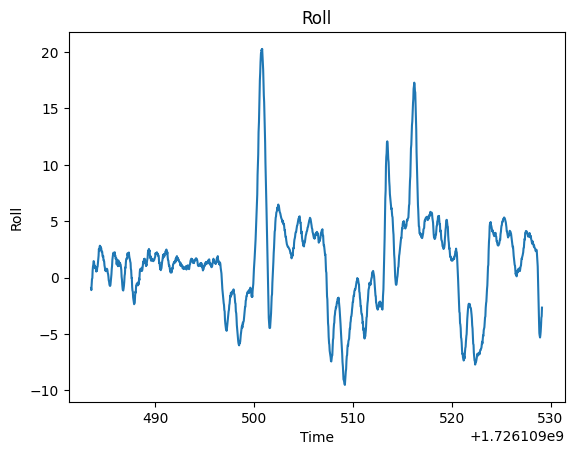

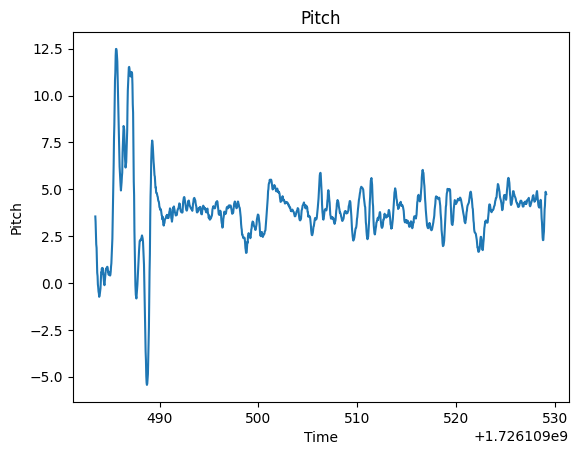

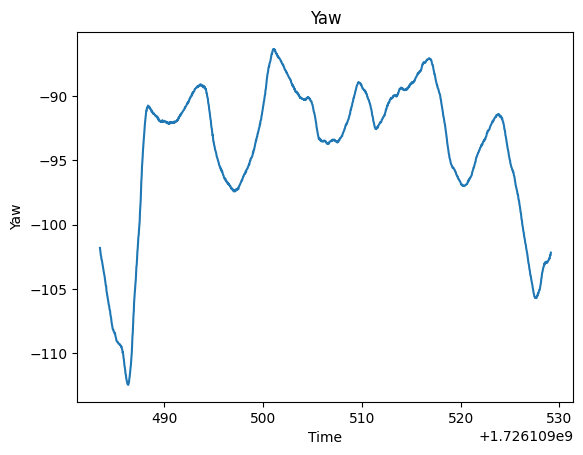

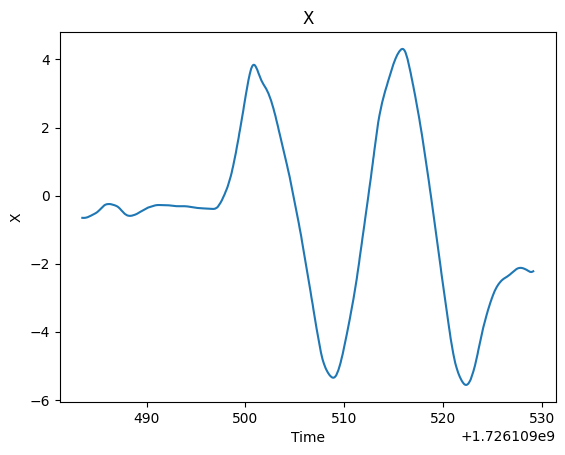

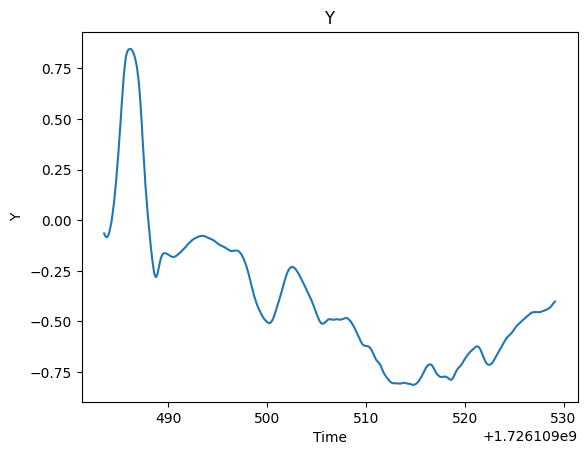

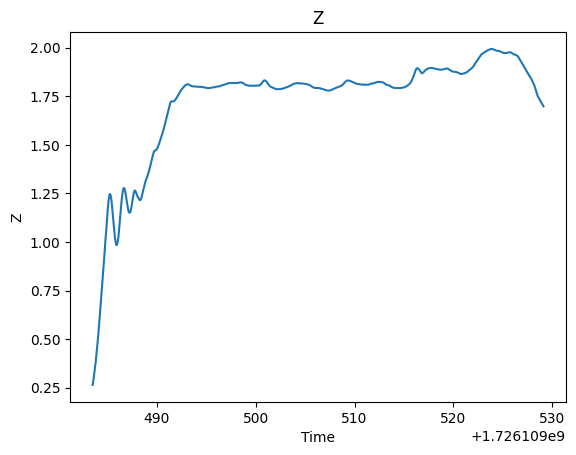

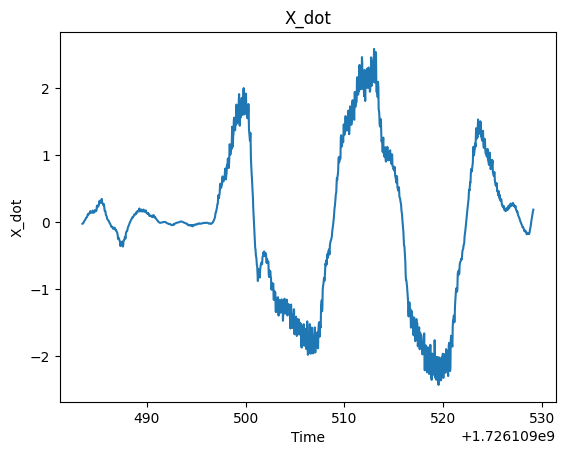

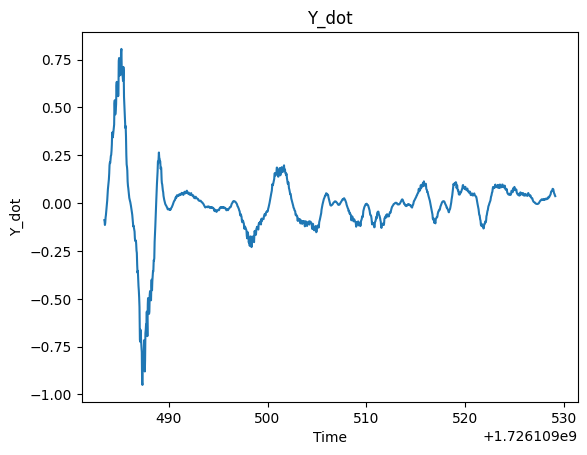

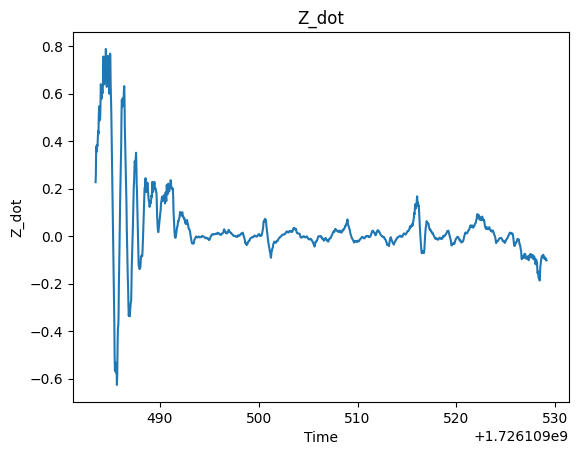

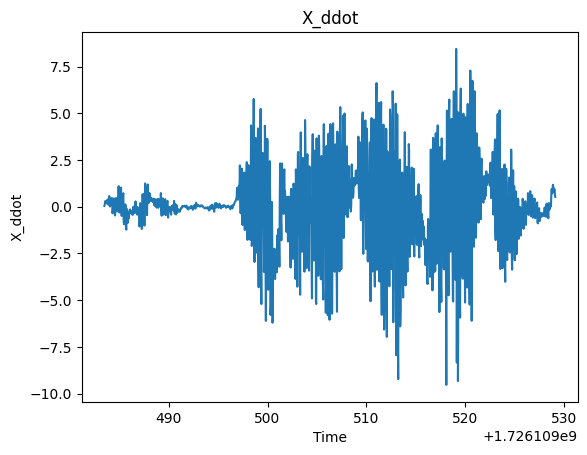

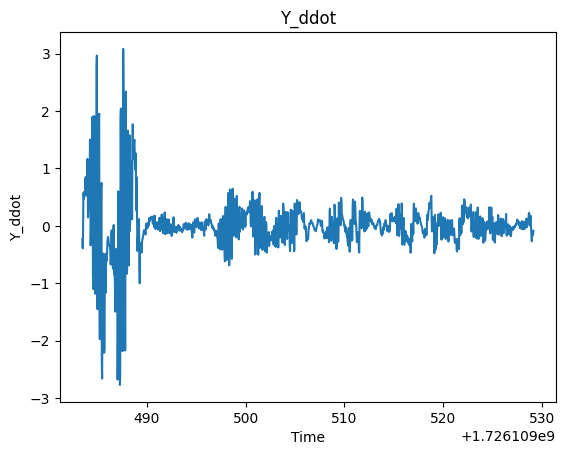

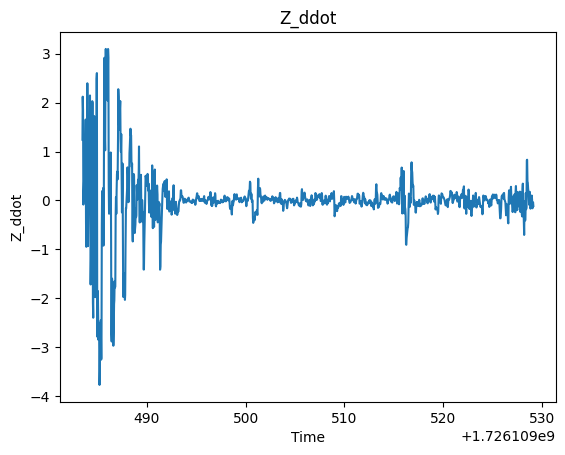

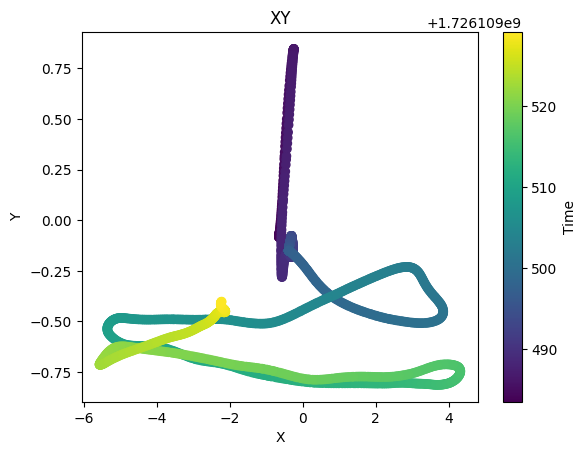

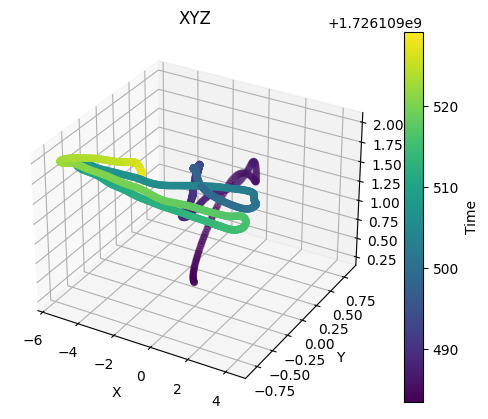

In [107]:
print('Mocap data time length:', len(mocap_time))
print('Mocap data Roll length:', len(mocap_Roll))
print('Mocap data Pitch length:', len(mocap_Pitch))
print('Mocap data Yaw length:', len(mocap_Yaw))

# plot Roll, Pitch, Yaw from mocap data on 3 different plots
plt.figure()
plt.plot(mocap_time, mocap_Roll)
plt.title('Roll')
plt.xlabel('Time')
plt.ylabel('Roll')
plt.show()

plt.figure()
plt.plot(mocap_time, mocap_Pitch)
plt.title('Pitch')
plt.xlabel('Time')
plt.ylabel('Pitch')
plt.show()

plt.figure()
plt.plot(mocap_time, mocap_Yaw)
plt.title('Yaw')
plt.xlabel('Time')
plt.ylabel('Yaw')
plt.show()

# plot X, Y, Z from mocap data on 3 different plots
plt.figure()
plt.plot(mocap_time, mocap_X)
plt.title('X')
plt.xlabel('Time')
plt.ylabel('X')
plt.show()

plt.figure()
plt.plot(mocap_time, mocap_Y)
plt.title('Y')
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(mocap_time, mocap_Z)
plt.title('Z')
plt.xlabel('Time')
plt.ylabel('Z')
plt.show()

# plot X_dot, Y_dot, Z_dot from mocap data on 3 different plots
plt.figure()
plt.plot(mocap_time, mocap_X_dot)
plt.title('X_dot')
plt.xlabel('Time')
plt.ylabel('X_dot')
plt.show()

plt.figure()
plt.plot(mocap_time, mocap_Y_dot)
plt.title('Y_dot')
plt.xlabel('Time')
plt.ylabel('Y_dot')
plt.show()

plt.figure()
plt.plot(mocap_time, mocap_Z_dot)
plt.title('Z_dot')
plt.xlabel('Time')
plt.ylabel('Z_dot')
plt.show()

# plot X_ddot, Y_ddot, Z_ddot from mocap data on 3 different plots
plt.figure()
plt.plot(mocap_time, mocap_X_ddot)
plt.title('X_ddot')
plt.xlabel('Time')
plt.ylabel('X_ddot')
plt.show()

plt.figure()
plt.plot(mocap_time, mocap_Y_ddot)
plt.title('Y_ddot')
plt.xlabel('Time')
plt.ylabel('Y_ddot')
plt.show()

plt.figure()
plt.plot(mocap_time, mocap_Z_ddot)
plt.title('Z_ddot')
plt.xlabel('Time')
plt.ylabel('Z_ddot')
plt.show()



import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# make plot of XY and 2d plot of XY with time as color
plt.figure()
plt.scatter(mocap_X, mocap_Y, c=mocap_time)
plt.title('XY')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label='Time')
plt.show()

# make 3d plot of XYZ with time as color
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(mocap_X, mocap_Y, mocap_Z, c=mocap_time)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('XYZ')
plt.colorbar(sc, label='Time')
plt.show()


# <center> IMU (Roll,Pitch,Yaw) + (Roll_dot,Pitch_dot,Yaw_dot) + (X_acc,Y_acc,Z_acc)

In [131]:
data['mavros/imu/data']
# print columns of the imu data
for col in data['mavros/imu/data'].columns:
    print(col)

rosbagTimestamp
header
seq
stamp
secs
nsecs
frame_id
orientation
x
y
z
w
orientation_covariance
angular_velocity
x.1
y.1
z.1
angular_velocity_covariance
linear_acceleration
x.2
y.2
z.2
linear_acceleration_covariance


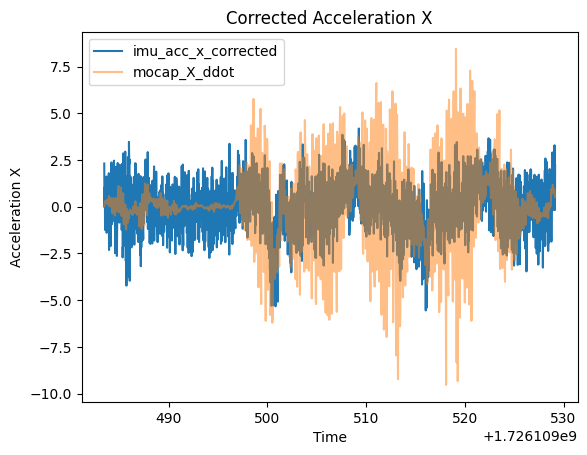

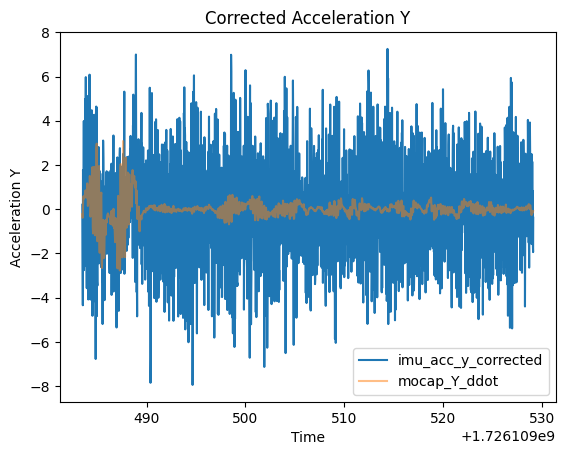

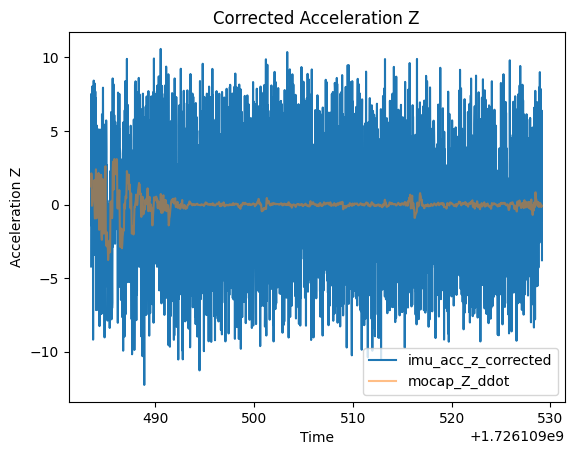

In [153]:
imu_time = data['mavros/imu/data']['rosbagTimestamp']/1e9
imu_time_shifted = imu_time - imu_time[0]
imu_Roll, imu_Pitch, imu_Yaw = [], [], []
for i in range(len(data['mavros/imu/data'])):
    R, P, Y = quaternion_to_euler(data['mavros/imu/data']['x'][i],
                                  data['mavros/imu/data']['y'][i],
                                  data['mavros/imu/data']['z'][i],
                                  data['mavros/imu/data']['w'][i])
    imu_Roll.append(np.radians(R))
    imu_Pitch.append(np.radians(P))
    imu_Yaw.append(np.radians(Y))

imu_Roll_rate = data['mavros/imu/data']['x.1']
imu_Pitch_rate = data['mavros/imu/data']['y.1']
imu_Yaw_rate = data['mavros/imu/data']['z.1']

g = 9.81  # Gravitational acceleration (m/s^2)

# Function to compute the rotation matrix from roll, pitch, yaw
def rotation_matrix_from_euler(roll, pitch, yaw):
    """
    Creates a rotation matrix from roll, pitch, yaw angles (in radians).
    """
    # Compute rotation matrices for roll, pitch, and yaw
    R_roll = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])
    
    R_pitch = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])
    
    R_yaw = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])
    
    # Combine the rotation matrices (Z * Y * X)
    R = R_yaw @ R_pitch @ R_roll
    return R

# Function to remove gravity from linear acceleration
def remove_gravity_from_acceleration(acc_x, acc_y, acc_z, roll, pitch, yaw):
    """
    Removes the gravity component from the linear acceleration in the body frame.
    
    acc_x, acc_y, acc_z: numpy arrays
        Arrays of linear acceleration in the body frame along the x, y, and z axes.
    roll, pitch, yaw: numpy arrays
        Arrays of roll, pitch, and yaw angles (in radians).
    
    Returns:
    acc_x_corrected, acc_y_corrected, acc_z_corrected: numpy arrays
        Corrected linear accelerations with gravity removed along the x, y, and z axes.
    """
    # Initialize corrected acceleration arrays
    acc_x_corrected = np.zeros_like(acc_x)
    acc_y_corrected = np.zeros_like(acc_y)
    acc_z_corrected = np.zeros_like(acc_z)
    
    # Gravity vector in the world frame (assume gravity points along the Z-axis)
    gravity_world = np.array([0, 0, g])
    
    # Loop over each time step and correct the acceleration
    for i in range(len(acc_x)):
        # Get the rotation matrix for the current orientation (roll, pitch, yaw)
        R = rotation_matrix_from_euler(roll[i], pitch[i], yaw[i])
        
        # Transform gravity vector from world frame to body frame
        gravity_body = R.T @ gravity_world  # Transpose R to rotate from world to body
        
        # Measured acceleration in body frame
        acc_body = np.array([acc_x[i], acc_y[i], acc_z[i]])
        
        # Subtract gravity from the body-frame acceleration
        acc_corrected = acc_body - gravity_body
        
        # Store the corrected acceleration
        acc_x_corrected[i] = acc_corrected[0]
        acc_y_corrected[i] = acc_corrected[1]
        acc_z_corrected[i] = acc_corrected[2]
    
    return acc_x_corrected, acc_y_corrected, acc_z_corrected

# Remove gravity from the linear acceleration
imu_acc_x_corrected, imu_acc_y_corrected, imu_acc_z_corrected = remove_gravity_from_acceleration(
    data['mavros/imu/data']['x.2'],
    data['mavros/imu/data']['y.2'],
    data['mavros/imu/data']['z.2'],
    imu_Roll, imu_Pitch, imu_Yaw
)

# rotate the acceleration data to the world frame
def rotate_acceleration_to_world_frame(acc_x, acc_y, acc_z, roll, pitch, yaw):
    """
    Rotates the linear acceleration from the body frame to the world frame.
    
    acc_x, acc_y, acc_z: numpy arrays
        Arrays of linear acceleration in the body frame along the x, y, and z axes.
    roll, pitch, yaw: numpy arrays
        Arrays of roll, pitch, and yaw angles (in radians).
    
    Returns:
    acc_x_world, acc_y_world, acc_z_world: numpy arrays
        Linear acceleration in the world frame along the x, y, and z axes.
    """
    # Initialize world-frame acceleration arrays
    acc_x_world = np.zeros_like(acc_x)
    acc_y_world = np.zeros_like(acc_y)
    acc_z_world = np.zeros_like(acc_z)
    
    # Loop over each time step and rotate the acceleration
    for i in range(len(acc_x)):
        # Get the rotation matrix for the current orientation (roll, pitch, yaw)
        R = rotation_matrix_from_euler(roll[i], pitch[i], yaw[i])
        
        # Measured acceleration in body frame
        acc_body = np.array([acc_x[i], acc_y[i], acc_z[i]])
        
        # Rotate the body-frame acceleration to the world frame
        acc_world = R @ acc_body
        
        # Store the world-frame acceleration
        acc_x_world[i] = acc_world[0]
        acc_y_world[i] = acc_world[1]
        acc_z_world[i] = acc_world[2]
    
    return acc_x_world, acc_y_world, acc_z_world

# Rotate the acceleration data to the world frame
imu_acc_x_corrected_world, imu_acc_y_corrected_world, imu_acc_z_corrected_world = rotate_acceleration_to_world_frame(
    imu_acc_x_corrected, imu_acc_y_corrected, imu_acc_z_corrected, imu_Roll, imu_Pitch, imu_Yaw
)

plt.plot(imu_time, imu_acc_x_corrected_world,label='imu_acc_x_corrected')
plt.plot(mocap_time, mocap_X_ddot,label='mocap_X_ddot',alpha=0.5)
plt.title('Corrected Acceleration X')
plt.xlabel('Time')
plt.ylabel('Acceleration X')
plt.legend()
plt.show()

plt.plot(imu_time, imu_acc_y_corrected_world,label='imu_acc_y_corrected')
plt.plot(mocap_time, mocap_Y_ddot,label='mocap_Y_ddot',alpha=0.5)
plt.title('Corrected Acceleration Y')
plt.xlabel('Time')
plt.ylabel('Acceleration Y')
plt.legend()
plt.show()

plt.plot(imu_time, imu_acc_z_corrected_world,label='imu_acc_z_corrected')
plt.plot(mocap_time, mocap_Z_ddot,label='mocap_Z_ddot',alpha=0.5)
plt.title('Corrected Acceleration Z')
plt.xlabel('Time')
plt.ylabel('Acceleration Z')
plt.legend()
plt.show()








# <center> Optic Flow (Camera data) <center>

In [56]:
data['optic_flow/camera/mean/x']

,rosbagTimestamp,data
0,1726109483479515236,-245.673935
1,1726109483488925236,-214.131119
2,1726109483502891154,-142.430420
3,1726109483519644910,-91.650337
4,1726109483536876087,-38.339165
...,...,...
2715,1726109529077929805,241.898880
2716,1726109529096810292,232.082535
2717,1726109529112937123,225.968948
2718,1726109529130869532,216.031647


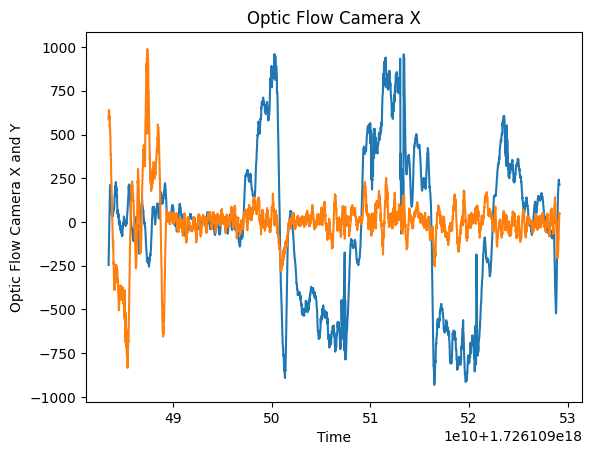

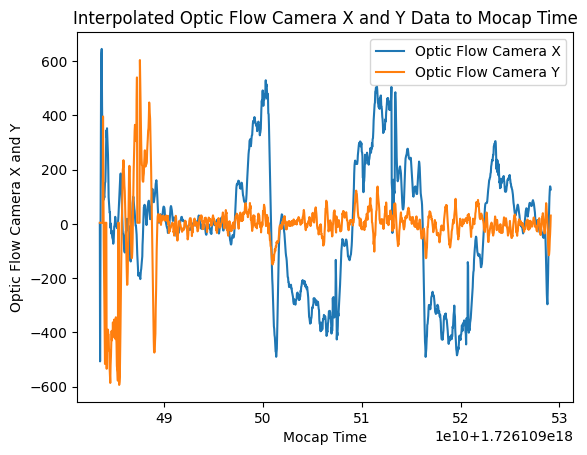

In [83]:
optic_flow_camera_x_time = data['optic_flow/camera/mean/x']['rosbagTimestamp']
optic_flow_camera_y_time = data['optic_flow/camera/mean/y']['rosbagTimestamp']
optic_flow_camera_x = data['optic_flow/camera/mean/x']['data']
optic_flow_camera_y = data['optic_flow/camera/mean/y']['data']

# print(optic_flow_camera_x_time==optic_flow_camera_y_time)

plt.plot(optic_flow_camera_x_time, optic_flow_camera_x)
plt.plot(optic_flow_camera_y_time, optic_flow_camera_y)
plt.title('Optic Flow Camera X')
plt.xlabel('Time')
plt.ylabel('Optic Flow Camera X and Y')
plt.show()



# interpolate optic flow camera data to mocap time
optic_flow_camera_x_mocap_interp = interpolate_data(optic_flow_camera_x_time, optic_flow_camera_x, mocap_time)
optic_flow_camera_y_mocap_interp = interpolate_data(optic_flow_camera_y_time, optic_flow_camera_y, mocap_time)

optic_flow_camera_x_mocap_interp=np.divide(optic_flow_camera_x_mocap_interp, mocap_Z)
optic_flow_camera_y_mocap_interp=np.divide(optic_flow_camera_y_mocap_interp, mocap_Z)

optic_flow_camera_x_mocap_interp[np.abs(optic_flow_camera_x_mocap_interp - np.median(optic_flow_camera_x_mocap_interp)) > 3 * np.std(optic_flow_camera_x_mocap_interp)] = np.median(optic_flow_camera_x_mocap_interp)
optic_flow_camera_y_mocap_interp[np.abs(optic_flow_camera_y_mocap_interp - np.median(optic_flow_camera_y_mocap_interp)) > 3 * np.std(optic_flow_camera_y_mocap_interp)] = np.median(optic_flow_camera_y_mocap_interp)



# Plot the interpolated data
plt.plot(mocap_time, optic_flow_camera_x_mocap_interp, label="Optic Flow Camera X")
plt.plot(mocap_time, optic_flow_camera_y_mocap_interp, label="Optic Flow Camera Y")
plt.title('Interpolated Optic Flow Camera X and Y Data to Mocap Time')
plt.xlabel('Mocap Time')
plt.ylabel('Optic Flow Camera X and Y')
plt.legend()
plt.show()


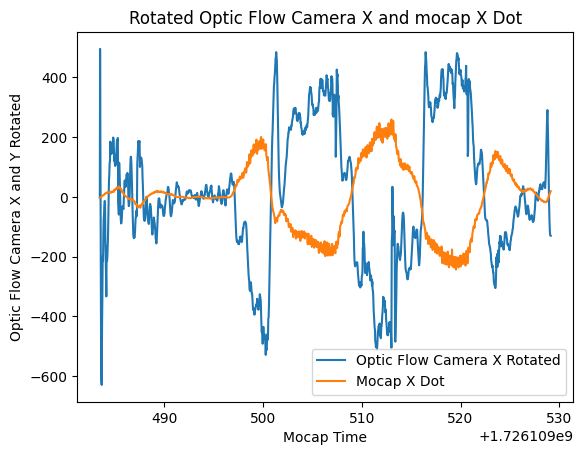

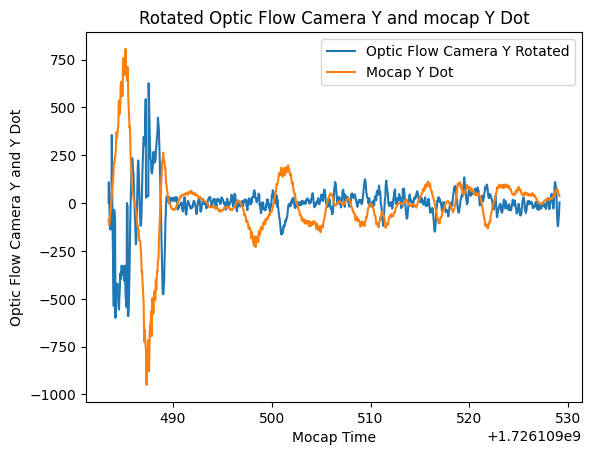

In [125]:
OFX=optic_flow_camera_y_mocap_interp
OFY=optic_flow_camera_x_mocap_interp
# apply a yaw rotation to the optic flow data using matrix multiplication
def rotate_optic_flow(OFX, OFY, Yaw):
    """
    input: OFX, OFY, Yaw
    output: rotated OFX, OFY
    """
    OFX_rot = np.cos(Yaw) * OFX + np.sin(Yaw) * OFY
    OFY_rot = -np.sin(Yaw) * OFX + np.cos(Yaw) * OFY
    return OFX_rot, OFY_rot

OFX_rot, OFY_rot = rotate_optic_flow(OFX, OFY, np.radians(mocap_Yaw))

# Plot the rotated optic flow data
plt.plot(mocap_time, np.multiply(OFX_rot,1), label="Optic Flow Camera X Rotated")
plt.plot(mocap_time,np.multiply(mocap_X_dot,100), label="Mocap X Dot")
# plt.plot(mocap_time, OFY_rot, label="Optic Flow Camera Y Rotated")
plt.title('Rotated Optic Flow Camera X and mocap X Dot')
plt.xlabel('Mocap Time')
plt.ylabel('Optic Flow Camera X and Y Rotated')
plt.legend()
plt.show()

plt.plot(mocap_time, np.multiply(OFY_rot,1), label="Optic Flow Camera Y Rotated")
plt.plot(mocap_time,np.multiply(mocap_Y_dot,1000), label="Mocap Y Dot")
plt.title('Rotated Optic Flow Camera Y and mocap Y Dot')
plt.xlabel('Mocap Time')
plt.ylabel('Optic Flow Camera Y and Y Dot')
plt.legend()
plt.show()



Scalar (meters/pixel) X: -0.004371641534474472
Scalar (meters/pixel) Y: -0.001075940355083128


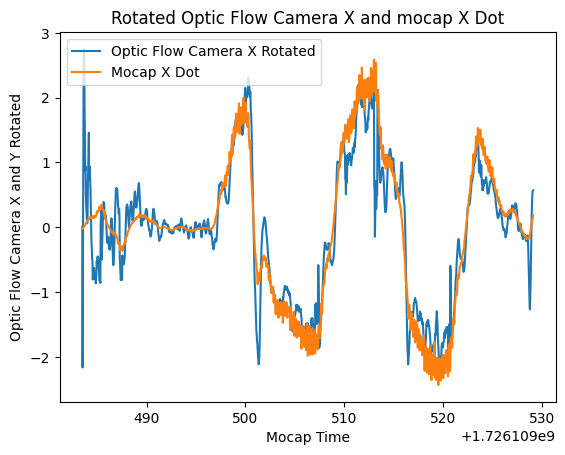

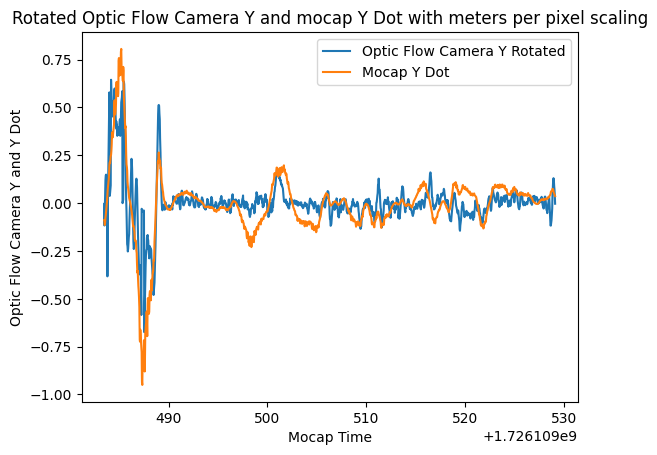

In [155]:
# Reshape the optic flow data to fit the linear regression model
OFX_rot = np.array(OFX_rot).reshape(-1, 1)
OFY_rot = np.array(OFY_rot).reshape(-1, 1)

# Perform linear regression
modelX = LinearRegression()
modelX.fit(OFX_rot, mocap_X_dot)

# The slope of the linear regression gives you the scalar (meters/pixel)
meters_per_pixel_X = modelX.coef_[0]

print(f"Scalar (meters/pixel) X: {meters_per_pixel_X}")

modelY = LinearRegression()
modelY.fit(OFY_rot, mocap_Y_dot)

# The slope of the linear regression gives you the scalar (meters/pixel)
meters_per_pixel_Y = modelY.coef_[0]

print(f"Scalar (meters/pixel) Y: {meters_per_pixel_Y}")

# Plot the rotated optic flow data
plt.plot(mocap_time, np.multiply(OFX_rot,meters_per_pixel_X), label="Optic Flow Camera X Rotated")
plt.plot(mocap_time,np.multiply(mocap_X_dot,1), label="Mocap X Dot")
# plt.plot(mocap_time, OFY_rot, label="Optic Flow Camera Y Rotated")
plt.title('Rotated Optic Flow Camera X and mocap X Dot')
plt.xlabel('Mocap Time')
plt.ylabel('Optic Flow Camera X and Y Rotated')
plt.legend()
plt.show()

plt.plot(mocap_time, np.multiply(OFY_rot,meters_per_pixel_Y), label="Optic Flow Camera Y Rotated")
plt.plot(mocap_time,np.multiply(mocap_Y_dot,1), label="Mocap Y Dot")
plt.title('Rotated Optic Flow Camera Y and mocap Y Dot with meters per pixel scaling')
plt.xlabel('Mocap Time')
plt.ylabel('Optic Flow Camera Y and Y Dot')
plt.legend()
plt.show()

## <center> Get final OF value (Global) <center>

In [ ]:
optic_flow_camera_x_time = data['optic_flow/camera/mean/x']['rosbagTimestamp']
optic_flow_camera_y_time = data['optic_flow/camera/mean/y']['rosbagTimestamp']
optic_flow_camera_x = data['optic_flow/camera/mean/x']['data']
optic_flow_camera_y = data['optic_flow/camera/mean/y']['data']

In [ ]:
########################################################################################
#################### Real Drone Parameters #############################################
########################################################################################
Real_m   = 0.086  # [kg] mass
Real_M   = 2.529  # [kg] mass
Real_mM  = Real_M+4*Real_m  # [kg] mass (total=2.529+4*0.086=2.897)
Real_l   = 0.2032 # [m] length
Real_r   = 0.1778 # [m] average body radius
Real_Ix  = 2*(Real_M*Real_r**2)/5 + 2*Real_m*Real_l**2 # [kg*m^2] moment of inertia
Real_Iy  = 2*(Real_M*Real_r**2)/5 + 2*Real_m*Real_l**2 # [kg*m^2] moment of inertia
Real_Iz  = 2*(Real_M*Real_r**2)/5 + 4*Real_m*Real_l**2 # [kg*m^2] moment of inertia
Real_Jr  = 2*(Real_M*Real_r**2)/5 # [kg*m^2] polar moment of inertia ### FAKE VALUE
Real_b   = 1.8311 # thrust coefficient
Real_d   = 0.01 # drag coefficient
Real_Dl  = 0.1 # drag coefficient from ground speed plus air speed
Real_Dr  = 0.1 # drag coefficient from rotation speed

print('Real Drone Parameters:')
print('Real_m:       ', Real_m)
print('Real_M:       ', Real_M)
print('Real_M_total: ', Real_mM)
print('Real_l:       ', Real_l)
print('Real_r:       ', Real_r)
print('Real_Ix:      ', Real_Ix)
print('Real_Iy:      ', Real_Iy)
print('Real_Iz:      ', Real_Iz)
print('Real_Jr:      ', Real_Jr)
print('Real_b:       ', Real_b)
print('Real_d:       ', Real_d)
print('Real_Dl:      ', Real_Dl)
print('Real_Dr:      ', Real_Dr)


# params = [m,l,Ix,Iy,Iz,Jr,b,d,Dl,Dr]
params = [Real_mM,Real_l,Real_Ix,Real_Iy,Real_Iz,Real_Jr,Real_b,Real_d,Real_Dl,Real_Dr]
g  = 9.81 # m/s^2

In [ ]:
def f_d(X, U):
    # Extract state variables
    x, vx, y, vy, z, vz, phi, dphi, theta, dtheta, psi, dpsi, wx, wy, wz = np.ravel(X)
    
    # Extract control inputs
    PWM1, PWM2, PWM3, PWM4 = np.ravel(U)
    
    # Compute intermediate variables
    U1 = b * (PWM1 + PWM2 + PWM3 + PWM4)
    U2 = b * (PWM4 + PWM1 - PWM2 - PWM3)
    U3 = b * (PWM3 + PWM4 - PWM1 - PWM2)
    U4 = d * (-PWM1 + PWM2 - PWM3 + PWM4)
    Omega = PWM2**(1/2) + PWM4**(1/2) - PWM1**(1/2) - PWM3**(1/2)

    # define drag dynamics
    vrx = vx - wx
    vry = vy - wy
    vrz = vz - wz
    
    new_x=x + vx * dt
    new_vx = (1/Real_mM) * (np.cos(phi) * np.sin(theta) * np.cos(psi) + np.sin(phi) * np.sin(psi)) * U1 - (Real_Dl * vrx / Real_mM) * dt
    new_y = y + vy * dt
    new_vy = (1/Real_mM) * (np.cos(phi) * np.sin(theta) * np.sin(psi) - np.sin(phi) * np.cos(psi)) * U1 - (Real_Dl * vry / Real_mM) * dt
    new_z = z + vz * dt
    new_vz = (1/Real_mM) * (np.cos(phi) * np.cos(theta)) * U1 - g - (Real_Dl * vrz / Real_mM) * dt
    new_phi = phi + dphi * dt
    new_dphi = dtheta * dpsi * (Real_Iy - Real_Iz) / Real_Ix - (Real_Jr * dtheta * Omega / Real_Ix) + (U2 * Real_l / Real_Ix) - (Real_Dr * dphi / Real_Ix) * dt
    new_theta = theta + dtheta * dt
    new_dtheta = dphi * dpsi * (Real_Iz - Real_Ix) / Real_Iy + (Real_Jr * dphi * Omega / Real_Iy) + (U3 * Real_l / Real_Iy) - (Real_Dr * dtheta / Real_Iy) * dt
    new_psi = psi + dpsi * dt
    new_dpsi = dphi * dtheta * (Real_Ix - Real_Iy) / Real_Iz + (U4 / Real_Iz) - (Real_Dr * dpsi / Real_Iz) * dt
    new_wx = wx
    new_wy = wy
    new_wz = wz
    
    new_X = np.atleast_2d(np.array([new_x, new_vx, new_y, new_vy, new_z, new_vz, new_phi, new_dphi, new_theta, new_dtheta, new_psi, new_dpsi,new_wx,new_wy,new_wz])).T

    return new_X

# write function as a continuous time function
def f_c(X, U):
    # Extract state variables
    x, vx, y, vy, z, vz, phi, dphi, theta, dtheta, psi, dpsi, wx, wy, wz = np.ravel(X)
    
    # Extract control inputs
    PWM1, PWM2, PWM3, PWM4 = np.ravel(U)
    
    # Compute intermediate variables
    U1 = b * (PWM1 + PWM2 + PWM3 + PWM4)
    U2 = b * (PWM4 + PWM1 - PWM2 - PWM3)
    U3 = b * (PWM3 + PWM4 - PWM1 - PWM2)
    U4 = d * (-PWM1 + PWM2 - PWM3 + PWM4)
    Omega = PWM2**(1/2) + PWM4**(1/2) - PWM1**(1/2) - PWM3**(1/2)

    # define drag dynamics
    vrx = vx - wx
    vry = vy - wy
    vrz = vz - wz
    
    dxdt=vx
    dvxdt = (1/Real_mM) * (np.cos(phi) * np.sin(theta) * np.cos(psi) + np.sin(phi) * np.sin(psi)) * U1 - (Real_Dl * vrx / Real_mM)
    dydt=vy
    dvydt = (1/Real_mM) * (np.cos(phi) * np.sin(theta) * np.sin(psi) - np.sin(phi) * np.cos(psi)) * U1 - (Real_Dl * vry / Real_mM)
    dzdt=vz
    dvzdt = (1/Real_mM) * (np.cos(phi) * np.cos(theta)) * U1 - g - (Real_Dl * vrz / Real_mM)
    dphidt=dphi
    ddphidt = dtheta * dpsi * (Real_Iy - Real_Iz) / Real_Ix - (Real_Jr * dtheta * Omega / Real_Ix) + (U2 * Real_l / Real_Ix) - (Real_Dr * dphi / Real_Ix)
    dthetadt= dtheta
    ddthetadt = dphi * dpsi * (Real_Iz - Real_Ix) / Real_Iy + (Real_Jr * dphi * Omega / Real_Iy) + (U3 * Real_l / Real_Iy) - (Real_Dr * dtheta / Real_Iy)
    dpsidt= dpsi
    ddpsidt = dphi * dtheta * (Real_Ix - Real_Iy) / Real_Iz + (U4 / Real_Iz) - (Real_Dr * dpsi / Real_Iz)
    dwx = 0
    dwy = 0
    dwz = 0
    

    new_X= scipy.integrate.odeint(lambda X, t: [dxdt, dvxdt, dydt, dvydt, dzdt, dvzdt, dphidt, ddphidt, dthetadt, ddthetadt, dpsidt, ddpsidt, dwx, dwy, dwz], np.ravel(X), [0, dt])[-1]
    new_X = np.atleast_2d(new_X).T
    return new_X

def h_d(X,U):
    # Extract the states
    x, vx, y, vy, z, vz, phi, dphi, theta, dtheta, psi, dpsi, wx, wy, wz = np.ravel(X)

    Px   = x
    Vx   = vx
    Py   = y
    Vy   = vy
    Pz   = z
    Vz   = vz
    R    = phi
    dR   = dphi
    P    = theta
    dP   = dtheta
    Yaw  = psi
    dYaw = dpsi
    Wx   = wx
    Wy   = wy
    Wz   = wz
    OFx  = vx/z
    OFy  = vy/z
    OFz  = vz/z
    Ax   = vx-wx
    Ay   = vy-wy
    Az   = vz-wz

    # Create clusters
    P_cluster = np.array([Px, Py, Pz])
    V_cluster = np.array([Vx, Vy, Vz])
    Attitude_cluster = np.array([R, P, Yaw])
    dAttitude_cluster = np.array([dR, dP, dYaw])
    W_cluster = np.array([Wx, Wy, Wz])
    OF_cluster = np.array([OFx, OFy, OFz])
    OF_cluster_XY = np.array([OFx, OFy])
    A_cluster = np.array([Ax, Ay, Az])

    # Y=np.vstack((P_cluster, V_cluster, Attitude_cluster, dAttitude_cluster, W_cluster, OF_cluster, A_cluster))
    Y=np.atleast_2d(np.hstack((dAttitude_cluster, OF_cluster, A_cluster))).T

    # Y = np.concatenate((P_cluster, V_cluster, Attitude_cluster, dAttitude_cluster, W_cluster, OF_cluster, A_cluster))
    # Only return the measured states
    # Y=np.atleast_2d(np.array([Vx, Vy, Vz, dR, dP, dYaw, Wx, Wy, Wz])).T
    return Y



In [ ]:
# Define Ynoisy
Ynoisy = copy.deepcopy(X_MPC_noisy)
# creat noisy measurements clusters
PM_cluster = np.array([Ynoisy[0], Ynoisy[2], Ynoisy[4]])
VM_cluster = np.array([Ynoisy[1], Ynoisy[3], Ynoisy[5]])
AttitudeM_cluster = np.array([Ynoisy[6], Ynoisy[8], Ynoisy[10]])
dAttitudeM_cluster = np.array([Ynoisy[7], Ynoisy[9], Ynoisy[11]])
WM_cluster = np.array([Ynoisy[12], Ynoisy[13], Ynoisy[14]])
OFM_cluster = np.array([Ynoisy[1]/Ynoisy[4], Ynoisy[3]/Ynoisy[4], Ynoisy[5]/Ynoisy[4]])
AM_cluster = np.array([Ynoisy[1]-Ynoisy[12], Ynoisy[3]-Ynoisy[13], Ynoisy[5]-Ynoisy[14]])

# Ynoise_small = 
# Ynoisy_small = np.vstack((PM_cluster, VM_cluster, AttitudeM_cluster, dAttitudeM_cluster, WM_cluster, OFM_cluster, AM_cluster))
Ynoisy_small = np.vstack((dAttitudeM_cluster,OFM_cluster, AM_cluster))

# Ynoisy_small = Ynoisy[[1,3,5,7,8,9,12,13,14],:]
# Ynoisy_small = np.atleast_2d([replace_outliers(np.divide(Ynoisy[1],Ynoisy[4])),replace_outliers(np.divide(Ynoisy[3],Ynoisy[4])),replace_outliers(np.divide(Ynoisy[5],Ynoisy[4])),Ynoisy[6],Ynoisy[8],Ynoisy[10],Ynoisy[12],Ynoisy[13],Ynoisy[14]])
# print('Ynoisy_small:',Ynoisy_small[0])

# Define the initial state estimate
# x0 = np.atleast_2d(X_MPC_noisy.T[0]).T
x0=np.atleast_2d(np.array([0.0,vx[0]+1,0.0,vy[0]+1,z[0],vz[0],0.0,0.0,0.0,0.0,psi[0],0.0,wx[0]+1,wy[0]+1,wz[0]])).T

# Define the process noise covariance matrix
Q = np.diag(np.array([0.0, 0.01, 0.0, 0.01, 0.0, 0.01, 0.0, 0.01, 0.0, 0.01, 0.0, 0.01, 0.01, 0.01, 0.01]))**2

# define the measurement noise covariance matrix based on clusters
PV_cluster = np.array([v[0], v[2], v[4]])
VV_cluster = np.array([v[1], v[3], v[5]])
AttitudeV_cluster = np.array([v[6], v[8], v[10]])
dAttitudeV_cluster = np.array([v[7], v[9], v[11]])
WV_cluster = np.array([v[12], v[13], v[14]])
OFV_cluster = np.array([.01, .01, .01])
AV_cluster = np.array([.01,.01,.01])


v_small = np.hstack([dAttitudeV_cluster,OFV_cluster,AV_cluster])
R = np.power(np.diag(v_small),2)
P0 = np.diag(np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,0.1,0.1,0.1]))**2


In [ ]:
# check that all inputs are a two-dimensional array
print("X_MPC_noisy:",X_MPC_noisy.shape) 
print('Ynoisy_small:',Ynoisy_small.shape)
print('x0:',x0.shape)
print('U:',U.shape)
print('Q:',Q.shape)
print('R:',R.shape)
print('P0:',P0.shape)
print('v_small:',v_small)


In [ ]:
xhat, P, s = EKF.ekf(Ynoisy_small, x0, f_c, h_d, Q, R, U, P0)

In [ ]:
x_hat=xhat[0,:] # x estimate
vx_hat=xhat[1,:] # vx estimate
y_hat=xhat[2,:] # y estimate
vy_hat=xhat[3,:] # vy estimate
z_hat=xhat[4,:] # z estimate
vz_hat=xhat[5,:] # vz estimate
phi_hat=xhat[6,:] # phi estimate
dphi_hat=xhat[7,:] # dphi estimate
theta_hat=xhat[8,:] # theta estimate
dtheta_hat=xhat[9,:] # dtheta estimate
psi_hat=xhat[10,:] # psi estimate
dpsi_hat=xhat[11,:] # dpsi estimate
wx_hat=xhat[12,:] # wx estimate
wy_hat=xhat[13,:] # wy estimate
wz_hat=xhat[14,:] # wz estimate
